# Decision Trees and Ensemble Learning

## Credit risk scoring project

**Dataset**

In [1]:
!wget https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv

--2022-10-12 01:56:12--  https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv [following]
--2022-10-12 01:56:12--  https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.008s  

2022-10-12 01:56:12 (21.2 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



### Librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('ggplot')

**Data cleanining**

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
# make all columns in lower
df.columns = df.columns.str.lower()

In [5]:
df.shape

(4455, 14)

**Mapping the target**

In [6]:
df['status'].value_counts(dropna=False)

1    3200
2    1254
0       1
Name: status, dtype: int64

In [7]:
df['status'] = df['status'].map({
    1:'ok',
    2:'default',
    0:'unk'
})

** Mapping categorical features **

In [8]:
def mapping_categorical(df, cat, cat_lst):
  to_lst = df[cat].value_counts().sort_index().index.to_list()
  cat_lst = cat_lst

  df[cat] = (
      df[cat].map({
          k:v for (k,v) in zip(to_lst, cat_lst)
      })
   )

In [9]:
cols = ['home', 'marital', 'records', 'job']

home_lst = ['unk', 'rent', 'owner', 'private', 'ignore', 'parents', 'other']
marital_lst = ['unk', 'single', 'married', 'widow', 'separated', 'divorced']
records_lst = ['no', 'yes', 'unk']
job_lst = ['unk', 'fixed', 'partime', 'freelance', 'others']
cat_lst = [home_lst, marital_lst, records_lst, job_lst]

for col, cat in zip(cols, cat_lst):
  mapping_categorical(df, col, cat)


In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


**Check numerical values**

In [11]:
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4455.0,763317.0,8703625.0,0.0,80.0,120.0,166.0,99999999.0
assets,4455.0,1060341.0,10217569.0,0.0,0.0,3500.0,6000.0,99999999.0
debt,4455.0,404382.0,6344253.0,0.0,0.0,0.0,0.0,99999999.0
amount,4455.0,1039.0,475.0,100.0,700.0,1000.0,1300.0,5000.0
price,4455.0,1463.0,628.0,105.0,1118.0,1400.0,1692.0,11140.0


One thing we immediately can notice is that the max value is 99999999 in some cases. This is quite suspicious. As it turns out, it’s an artificial value — this is how missing values are encoded in this dataset.

In [12]:
def fix_missing_values(df, val_to_rep, rep, *f_lst):
  for f in f_lst:
    df[f] = df[f].replace(val_to_rep, rep)

In [13]:
fix_missing_values(df, 99999999.0, np.nan, ['income', 'assets', 'debt'])

In [14]:
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4421.0,131.0,86.0,0.0,80.0,120.0,165.0,959.0
assets,4408.0,5403.0,11573.0,0.0,0.0,3000.0,6000.0,300000.0
debt,4437.0,343.0,1246.0,0.0,0.0,0.0,0.0,30000.0
amount,4455.0,1039.0,475.0,100.0,700.0,1000.0,1300.0,5000.0
price,4455.0,1463.0,628.0,105.0,1118.0,1400.0,1692.0,11140.0


In [15]:
df.isna().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

We notice that there’s one row with “unknown” status: we don’t know whether this client
managed to pay back the loan or not. For our project, this row is not useful

In [16]:
df = df[df.status != 'unk']

# Dataset preparation

Separate target from features. Since our objective is to determine if somebody fails to pay back their credit, the positive class is “default”. This means that y is “1” if the client defaulted and
“0” otherwise.

In [17]:
data, target = df.drop(columns=['status']), df['status'].map({'ok':0, 'default':1})

In [18]:
target.head()

0    0
1    0
2    1
3    0
4    0
Name: status, dtype: int64

**Spliting data**

In [19]:
from sklearn import model_selection

X_full_train, X_test, y_full_train, y_test = model_selection.train_test_split(
    data,
    target,
    test_size=.2,
    random_state=11,
)
X_train, X_dev, y_train, y_dev = model_selection.train_test_split(
    X_full_train,
    y_full_train,
    test_size=.25,
    random_state=11,
)

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

((2672, 13), (2672,), (891, 13), (891,), (891, 13), (891,))

**impute missing values and make pipelines**

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import (
    make_column_selector as selector, 
    ColumnTransformer, 
    make_column_transformer,
)    
from sklearn.pipeline import Pipeline, make_pipeline


numerical = selector(dtype_include=np.number)(data)
categorical = selector(dtype_include=object)(data)

num_imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0)
cat_imputer = SimpleImputer(strategy='constant', fill_value='unk')
cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

cat_preprocessor = Pipeline([
    ('category_imputer', cat_imputer),
    ('category_encoder', cat_encoder)
])

processor = ColumnTransformer([
    ('numeric', num_imputer, numerical),
    ('category', cat_preprocessor, categorical)
])

# Models

## Decision Trees

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(processor, DecisionTreeClassifier())
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['seniority', 'time', 'age',
                                                   'expenses', 'income',
                                                   'assets', 'debt', 'amount',
                                                   'price']),
                                                 ('category',
                                                  Pipeline(steps=[('category_imputer',
                                                                   SimpleImputer(fill_value='unk',
                                                                                 strategy='constant')),
                                                                  ('category_encoder',
     

In [22]:
from sklearn import metrics

y_pred = dt.predict_proba(X_train)[:, 1]
metrics.roc_auc_score(y_train, y_pred)

1.0

In [23]:
y_pred = dt.predict_proba(X_dev)[:, 1]
metrics.roc_auc_score(y_dev, y_pred)

0.6551003850718073

In [24]:
metrics.recall_score(y_dev, y_pred)

0.49809885931558934

We just observed a case of overfitting. The tree learned the training data so well that it simply memorized the outcome for each customer. However, when we applied it to the validation set, the model failed. The rules it extracted from data turned out too specific to the training set, so it worked poorly for customers it didn’t see during training. In such cases, we say that the model cannot generalize. Overfitting happens when we have a complex model with enough power to remember all the training data. If we force the model to be simpler, we can make it less powerful, and improve the model’s ability to generalize. There are multiple ways of controlling the complexity of a tree. One of the options is restricting its size: we can specify the max_depth parameter, which controls the maximal number of levels. The more levels a tree has, the more complex rules it can learn.

The default value for the `max_depth` parameter is `None`, which means that the tree can grow
as large as possible. We can try a smaller value and compare the results.

In [25]:
max_depth = 2

dt = make_pipeline(processor, DecisionTreeClassifier(max_depth=max_depth))
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['seniority', 'time', 'age',
                                                   'expenses', 'income',
                                                   'assets', 'debt', 'amount',
                                                   'price']),
                                                 ('category',
                                                  Pipeline(steps=[('category_imputer',
                                                                   SimpleImputer(fill_value='unk',
                                                                                 strategy='constant')),
                                                                  ('category_encoder',
     

In [26]:
from sklearn.tree import export_text


tree_text = export_text(dt[1])
print(tree_text)

|--- feature_11 <= 0.50
|   |--- feature_12 <= 2.50
|   |   |--- class: 0
|   |--- feature_12 >  2.50
|   |   |--- class: 1
|--- feature_11 >  0.50
|   |--- feature_0 <= 6.50
|   |   |--- class: 1
|   |--- feature_0 >  6.50
|   |   |--- class: 0



In [27]:
y_pred = dt.predict_proba(X_train)[:, 1]
print(f"AUC train set: {metrics.roc_auc_score(y_train, y_pred)}")

AUC train set: 0.7061968339811842


In [28]:
y_pred = dt.predict_proba(X_dev)[:, 1]
print(f"AUC dev set: {metrics.roc_auc_score(y_dev, y_pred)}")

AUC dev set: 0.6685264343319367


In [29]:
y_pred_rec = dt.predict(X_dev)
print(f"Recall dev set: {metrics.recall_score(y_dev, y_pred_rec)}")

Recall dev set: 0.38022813688212925


In [30]:
auc = []

for depth in [5, 8, 15, 25, 30, None]:
  dt = make_pipeline(processor, DecisionTreeClassifier(max_depth=depth))
  dt.fit(X_train, y_train)
  preds = dt.predict_proba(X_dev)[:, 1]
  score = metrics.roc_auc_score(y_dev, preds)
  auc.append((depth, score))
  # print(f"max_depth: {depth} ---> auc: {score}")

for depth, score in auc:
  print(f"max_depth: {depth} ---> auc: {score:.3f}")

max_depth: 5 ---> auc: 0.767
max_depth: 8 ---> auc: 0.726
max_depth: 15 ---> auc: 0.659
max_depth: 25 ---> auc: 0.667
max_depth: 30 ---> auc: 0.657
max_depth: None ---> auc: 0.668


In [31]:
for i in dt.get_params().keys():
  print(i)

memory
steps
verbose
columntransformer
decisiontreeclassifier
columntransformer__n_jobs
columntransformer__remainder
columntransformer__sparse_threshold
columntransformer__transformer_weights
columntransformer__transformers
columntransformer__verbose
columntransformer__verbose_feature_names_out
columntransformer__numeric
columntransformer__category
columntransformer__numeric__add_indicator
columntransformer__numeric__copy
columntransformer__numeric__fill_value
columntransformer__numeric__missing_values
columntransformer__numeric__strategy
columntransformer__numeric__verbose
columntransformer__category__memory
columntransformer__category__steps
columntransformer__category__verbose
columntransformer__category__category_imputer
columntransformer__category__category_encoder
columntransformer__category__category_imputer__add_indicator
columntransformer__category__category_imputer__copy
columntransformer__category__category_imputer__fill_value
columntransformer__category__category_imputer__m

In [32]:
auc = []

for min_leaf in [1, 5, 10, 15, 20, 50, 100, 200]:
  for depth in [5, 8, 15, 25, 30, None]:
    dt.set_params(
        decisiontreeclassifier__min_samples_leaf=min_leaf, 
        decisiontreeclassifier__max_depth=depth
    )
    dt.fit(X_train, y_train)
    preds = dt.predict_proba(X_dev)[:, 1]
    res = metrics.roc_auc_score(y_dev, preds)
    auc.append((min_leaf, depth, res))

for min_leaf, depth, score in auc:
  print(f"min samples leaf: {min_leaf}, max_depth: {depth} ---> AUC: {score:.3f}")

min samples leaf: 1, max_depth: 5 ---> AUC: 0.767
min samples leaf: 1, max_depth: 8 ---> AUC: 0.730
min samples leaf: 1, max_depth: 15 ---> AUC: 0.660
min samples leaf: 1, max_depth: 25 ---> AUC: 0.659
min samples leaf: 1, max_depth: 30 ---> AUC: 0.656
min samples leaf: 1, max_depth: None ---> AUC: 0.652
min samples leaf: 5, max_depth: 5 ---> AUC: 0.768
min samples leaf: 5, max_depth: 8 ---> AUC: 0.743
min samples leaf: 5, max_depth: 15 ---> AUC: 0.717
min samples leaf: 5, max_depth: 25 ---> AUC: 0.717
min samples leaf: 5, max_depth: 30 ---> AUC: 0.711
min samples leaf: 5, max_depth: None ---> AUC: 0.722
min samples leaf: 10, max_depth: 5 ---> AUC: 0.768
min samples leaf: 10, max_depth: 8 ---> AUC: 0.765
min samples leaf: 10, max_depth: 15 ---> AUC: 0.765
min samples leaf: 10, max_depth: 25 ---> AUC: 0.767
min samples leaf: 10, max_depth: 30 ---> AUC: 0.765
min samples leaf: 10, max_depth: None ---> AUC: 0.764
min samples leaf: 15, max_depth: 5 ---> AUC: 0.772
min samples leaf: 15, max

In [33]:
sorted(auc, key=lambda x: x[-1], reverse=True)

[(15, 30, 0.7908624155384951),
 (15, 15, 0.7907443510692402),
 (15, 25, 0.79065655954082),
 (15, None, 0.7890218207357536),
 (20, 25, 0.7822649003414788),
 (15, 8, 0.7815595408200333),
 (20, 30, 0.7812447022353539),
 (20, None, 0.7808693177690054),
 (20, 15, 0.7801276307185585),
 (100, 8, 0.779812792133879),
 (100, 15, 0.779812792133879),
 (100, None, 0.779812792133879),
 (100, 25, 0.7795615267249522),
 (100, 30, 0.7795615267249522),
 (20, 8, 0.7787199389697513),
 (50, 8, 0.77770276815771),
 (50, 25, 0.7748268387784263),
 (50, 30, 0.7748268387784263),
 (20, 5, 0.7740276331403937),
 (50, 15, 0.7733828195006176),
 (50, None, 0.7733828195006176),
 (15, 5, 0.7724050035116611),
 (200, 8, 0.7684786030854182),
 (200, 15, 0.7684786030854182),
 (200, 25, 0.7684786030854182),
 (200, 30, 0.7684786030854182),
 (200, None, 0.7684786030854182),
 (5, 5, 0.7677702162698894),
 (10, 5, 0.7677005885059698),
 (10, 25, 0.7665259984015886),
 (1, 5, 0.7665108619311716),
 (50, 5, 0.7665108619311714),
 (10, 30

The best AUC is 79.15% with parameters min_sample_leaf=15 and
max_depth=15

In [34]:
dt.set_params(
        decisiontreeclassifier__min_samples_leaf=15, 
        decisiontreeclassifier__max_depth=15
    )
dt.fit(X_train, y_train)

preds = dt.predict_proba(X_dev)[:, 1]
pred_r = dt.predict(X_dev)

print(f"AUC:{metrics.roc_auc_score(y_dev, preds)}")
print(f"Recall:{metrics.recall_score(y_dev, pred_r)}")

AUC:0.7901752197815504
Recall:0.4828897338403042


In [35]:
!pip install optuna --quiet

     |████████████████████████████████| 348 kB 12.6 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 209 kB 35.9 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 44.2 MB/s 
     |████████████████████████████████| 147 kB 42.9 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 


In [36]:
X_train_cp = X_train.copy()
X_test_cp = X_test.copy()
X_full = data.copy()


X_full.loc[:, numerical] = num_imputer.fit_transform(X_full[numerical])
X_full.loc[:, categorical] = cat_imputer.fit_transform(X_full[categorical])
X_full.loc[:, categorical] = cat_encoder.fit_transform(X_full[categorical])

X_train_cp.loc[:, numerical] = num_imputer.fit_transform(X_train_cp[numerical])
X_train_cp.loc[:, categorical] = cat_imputer.fit_transform(X_train_cp[categorical])
X_train_cp.loc[:, categorical] = cat_encoder.fit_transform(X_train_cp[categorical])

X_test_cp.loc[:, numerical] = num_imputer.transform(X_test_cp[numerical])
X_test_cp.loc[:, categorical] = cat_imputer.transform(X_test_cp[categorical])
X_test_cp.loc[:, categorical] = cat_encoder.transform(X_test_cp[categorical])

In [37]:
import optuna
from functools import partial


def optimize(trial, x, y):
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 200)
  max_depth = trial.suggest_int("max_depth", 5, 30)
  # min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
  max_features = trial.suggest_categorical("max_features", ["log2", "sqrt", None])

  model = DecisionTreeClassifier(
      min_samples_leaf=min_samples_leaf, 
      max_depth=max_depth,
      # min_samples_split=min_samples_split,
      max_features=max_features,
  )

  kf = model_selection.KFold(n_splits=5)
  auc = []

  for idx in kf.split(X=x, y=y):
    train_idx, dev_idx = idx[0], idx[1]
    xtrain = x[train_idx]
    ytrain = y[train_idx]

    xdev = x[dev_idx]
    ydev = y[dev_idx]

    model.fit(xtrain, ytrain)

    preds = model.predict_proba(xdev)[:, 1]
    fold_accuracy = metrics.roc_auc_score(ydev, preds)
    auc.append(fold_accuracy)

    return -1 * np.mean(auc)

optimization_function = partial(optimize,x=X_full.values, y=target.values)
study = optuna.create_study(direction="minimize")
study.optimize(optimization_function, n_trials=50)

[I 2022-10-12 01:56:33,941] A new study created in memory with name: no-name-6535d65c-0402-4e50-93f2-7546b2564607
[I 2022-10-12 01:56:33,956] Trial 0 finished with value: -0.7278520804755373 and parameters: {'min_samples_leaf': 107, 'max_depth': 20, 'max_features': 'log2'}. Best is trial 0 with value: -0.7278520804755373.
[I 2022-10-12 01:56:34,001] Trial 1 finished with value: -0.814074963166184 and parameters: {'min_samples_leaf': 107, 'max_depth': 14, 'max_features': None}. Best is trial 1 with value: -0.814074963166184.
[I 2022-10-12 01:56:34,025] Trial 2 finished with value: -0.8056381141086216 and parameters: {'min_samples_leaf': 71, 'max_depth': 29, 'max_features': None}. Best is trial 1 with value: -0.814074963166184.
[I 2022-10-12 01:56:34,038] Trial 3 finished with value: -0.7656543717929177 and parameters: {'min_samples_leaf': 36, 'max_depth': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: -0.814074963166184.
[I 2022-10-12 01:56:34,050] Trial 4 finished with value:

In [38]:
#81.923, 82.278 83.18

dt = make_pipeline(processor, DecisionTreeClassifier(
    min_samples_leaf=52, 
    max_depth=17,  
    max_features=None
))

dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_test)[:,1]
pred_r = dt.predict(X_test)

print(f"AUC: {metrics.roc_auc_score(y_test, y_pred):.3f}")
print(f"Recall: {metrics.recall_score(y_test, pred_r):.3f}")

AUC: 0.773
Recall: 0.471


# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=3)
rf.fit(X_train_cp, y_train)
y_pred = rf.predict_proba(X_test_cp)[:, 1]

metrics.roc_auc_score(y_test, y_pred)

0.8041823469038659

The number of trees in the ensemble is an important parameter and it influences the
performance of the model. Usually, a model with more trees is better than a model with fewer
trees. On the other hand, adding too many trees is not always helpful.

n_estimator:120 >> score:0.826
n_estimator:300 >> score:0.824
n_estimator:500 >> score:0.824
n_estimator:800 >> score:0.826
n_estimator:1200 >> score:0.826


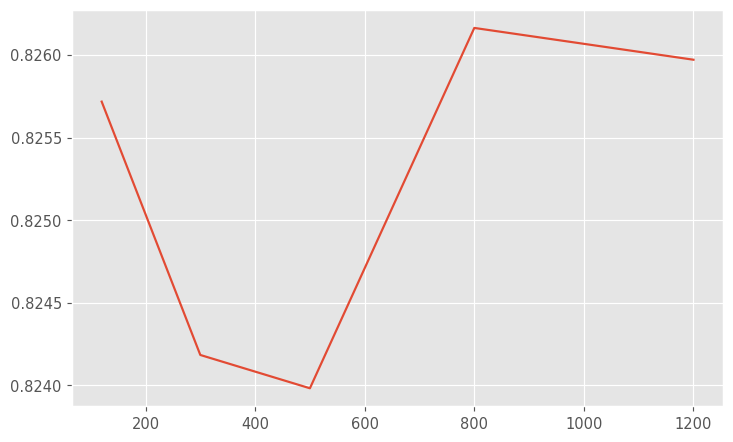

In [41]:
auc = []
for i in [120, 300, 500, 800, 1200]:
  rf = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=3)
  rf.fit(X_train_cp, y_train)
  y_pred = rf.predict_proba(X_test_cp)[:, 1]
  score = metrics.roc_auc_score(y_test, y_pred)
  auc.append(score)
  print(f"n_estimator:{i} >> score:{score:.3f}")

plt.figure(figsize=(8, 5), dpi=105)
plt.plot([120, 300, 500, 800, 1200], auc)
plt.show();

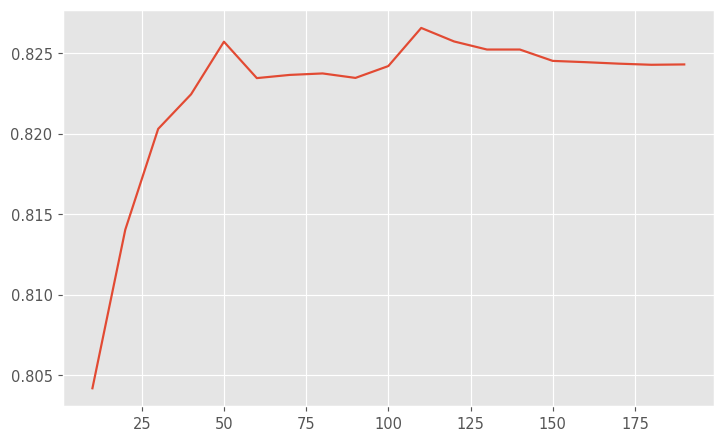

In [47]:
auc = []
for i in range(10, 200, 10):
  rf = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=3)
  rf.fit(X_train_cp, y_train)
  y_pred = rf.predict_proba(X_test_cp)[:, 1]
  score = metrics.roc_auc_score(y_test, y_pred)
  auc.append(score)
  # print(f"n_estimator:{i} >> score:{score}")

plt.figure(figsize=(8, 5), dpi=105)
plt.plot(range(10, 200, 10), auc)
plt.show();

## Parameter tuning for random forest

In [49]:
def optimize(trial, x, y):
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 200)
  max_depth = trial.suggest_int("max_depth", 5, 30)
  n_estimators = trial.suggest_int("n_estimators", 10, 200)
  criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

  model = RandomForestClassifier(
      min_samples_leaf=min_samples_leaf, 
      max_depth=max_depth,
      n_estimators=n_estimators,
      criterion=criterion,
  )

  kf = model_selection.KFold(n_splits=5)
  auc = []

  for idx in kf.split(X=x, y=y):
    train_idx, dev_idx = idx[0], idx[1]
    xtrain = x[train_idx]
    ytrain = y[train_idx]

    xdev = x[dev_idx]
    ydev = y[dev_idx]

    model.fit(xtrain, ytrain)

    preds = model.predict_proba(xdev)[:, 1]
    fold_accuracy = metrics.roc_auc_score(ydev, preds)
    auc.append(fold_accuracy)

    return -1 * np.mean(auc)

optimization_function = partial(optimize,x=X_full.values, y=target.values)
study = optuna.create_study(direction="minimize")
study.optimize(optimization_function, n_trials=50)

[I 2022-10-12 02:30:04,418] A new study created in memory with name: no-name-f0d2faa5-254f-4352-98e7-0d595a07ba97
[I 2022-10-12 02:30:04,875] Trial 0 finished with value: -0.8521344561296549 and parameters: {'min_samples_leaf': 38, 'max_depth': 26, 'n_estimators': 127, 'criterion': 'gini'}. Best is trial 0 with value: -0.8521344561296549.
[I 2022-10-12 02:30:05,309] Trial 1 finished with value: -0.8400555047502921 and parameters: {'min_samples_leaf': 186, 'max_depth': 23, 'n_estimators': 152, 'criterion': 'entropy'}. Best is trial 0 with value: -0.8521344561296549.
[I 2022-10-12 02:30:05,372] Trial 2 finished with value: -0.8319361885891379 and parameters: {'min_samples_leaf': 105, 'max_depth': 25, 'n_estimators': 18, 'criterion': 'gini'}. Best is trial 0 with value: -0.8521344561296549.
[I 2022-10-12 02:30:05,941] Trial 3 finished with value: -0.8438722501651171 and parameters: {'min_samples_leaf': 116, 'max_depth': 28, 'n_estimators': 184, 'criterion': 'gini'}. Best is trial 0 with v

In [50]:
# {'min_samples_leaf': 2, 'max_depth': 9, 'n_estimators': 55, 'criterion': 'entropy'}
rf = RandomForestClassifier(
    n_estimators=55,
    criterion="entropy",
    max_depth=9,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=3
)

rf.fit(X_train_cp, y_train)

y_pred = rf.predict_proba(X_test_cp)[:, 1]
metrics.roc_auc_score(y_test, y_pred)

0.8210253653291628